In [1]:
import kaggle
import pandas as pd
import zipfile
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

#biblioteca para fazer fazer a regressão
from sklearn.tree import DecisionTreeRegressor

#biblioteca para calcular uma métrica de avaliação
from sklearn.metrics import mean_squared_error

In [2]:
#kaggle.api.authenticate() #Autenticação tem que ocorrer usando o .json de acesso com suas credenciais do Kaggle
#criar link com os metadados das pesquisas e locais dos dados

In [17]:
!kaggle datasets download -d andrevandor/hdi-1990-2018-20200529


  0%|          | 0.00/623k [00:00<?, ?B/s]
100%|##########| 623k/623k [00:00<00:00, 19.5MB/s]


In [18]:
data_zip = zipfile.ZipFile('.\hdi-1990-2018-20200529.zip')
data_zip.extractall('.\data')
data_zip.close()

In [11]:
df = pd.read_excel('.\data\HDI_1990_2018.xlsx')

In [12]:
df.shape

(5481, 6)

In [13]:
df.head()

,Paises,Ano,Expectativa de vida no nascimento,Anos esperados de escolaridade,Média de anos de escolaridade,Renda nacional bruta (RNB) per capita (PPP US$)
0,Norway,1990,76.729,14.0,10.47,17910.0
1,Switzerland,1990,77.568,13.4,10.19,28170.0
2,Ireland,1990,74.809,12.1,9.73,12750.0
3,Germany,1990,75.488,14.4,8.77,19640.0
4,China,1990,69.145,8.8,5.34,17760.0


In [14]:
def EDA (df):
    eda_df = {}
    eda_df['Qtde_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Qtde_Unicos'] = df.count()
    
    colunas = sorted(df.columns.tolist(), key=str.lower, reverse=False)
    eda_df['Qtde_Unicos'] = filtered_result = list(map(lambda x: len(df[x].unique().tolist()), colunas))
    
    eda_df['Media'] = df.mean().round(3)
    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['STD'] = df.std().round(3)
    
    return pd.DataFrame(eda_df)

In [15]:
EDA(df.drop(['Ano','Paises'], axis = 1))

,Qtde_NaN,%_NaN,DType,Qtde_Unicos,Media,Min,Max,STD
Expectativa de vida no nascimento,84,0.02,float64,372,68.237,26.172,84.68700,9.566
Anos esperados de escolaridade,279,0.05,float64,4911,11.787,2.100,23.30000,3.348
Média de anos de escolaridade,551,0.10,float64,431,7.469,0.290,14.13215,3.163
Renda nacional bruta (RNB) per capita (PPP US$),450,0.08,float64,2507,13297.971,270.000,131510.00000,16413.508


In [16]:
df_1 = df.copy()
df_1['Expectativa de vida no nascimento'].fillna(df_1['Expectativa de vida no nascimento'].mean(), inplace = True)
df_1['Anos esperados de escolaridade'].fillna(df_1['Anos esperados de escolaridade'].mean(), inplace = True)
df_1['Média de anos de escolaridade'].fillna(df_1['Média de anos de escolaridade'].mean(), inplace = True)
df_1['Renda nacional bruta (RNB) per capita (PPP US$)'].\
    fillna(df_1['Renda nacional bruta (RNB) per capita (PPP US$)'].mode()[0], inplace = True)

EDA(df_1.drop(['Ano','Paises'], axis = 1))

,Qtde_NaN,%_NaN,DType,Qtde_Unicos,Media,Min,Max,STD
Expectativa de vida no nascimento,0,0.0,float64,372,68.237,26.172,84.68700,9.492
Anos esperados de escolaridade,0,0.0,float64,4911,11.787,2.100,23.30000,3.262
Média de anos de escolaridade,0,0.0,float64,431,7.469,0.290,14.13215,3.000
Renda nacional bruta (RNB) per capita (PPP US$),0,0.0,float64,2506,12311.274,270.000,131510.00000,16067.583


In [19]:
paises = df_1.Paises.unique()

In [20]:
index_paises = []
for i in range(len(paises)):
    index_paises.append (df_1[df_1.Paises == paises[i]].index)

In [21]:
df_2 = pd.DataFrame()
for i in range(len(index_paises)):
    df_2 = pd.concat([df_2, df_1.iloc[index_paises[i]]], axis = 0)

In [22]:
df_2.reset_index(inplace=True)
df_2.drop('index', axis=1, inplace=True)

In [24]:
index_paises = []
for i in range(len(paises)):
    index_paises.append (df_2[df_2.Paises == paises[i]].index)

In [31]:
df_3 = df_2.copy()

#número de (anos-1) para teste
frequencia = 3

for i in range(len(paises)):
    
    df_3.loc[index_paises[i],'Diff_1'] = df_3.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .diff(frequencia - 1)
    df_3.loc[index_paises[i],'Diff_2'] = df_3.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .diff(frequencia - 1)
    df_3.loc[index_paises[i],'Diff_3'] = df_3.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .diff(frequencia - 1)
    df_3.loc[index_paises[i],'Diff_4'] = df_3.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .diff(frequencia - 1)
    
    df_3.loc[index_paises[i], 'Med_1'] = df_3.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .rolling(frequencia).mean().round(2)
    df_3.loc[index_paises[i], 'Med_2'] = df_3.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .rolling(frequencia).mean().round(2)
    df_3.loc[index_paises[i], 'Med_3'] = df_3.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .rolling(frequencia).mean().round(2)
    df_3.loc[index_paises[i], 'Med_4'] = df_3.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .rolling(frequencia).mean().round(2)
    
    df_3.loc[index_paises[i], 'Var_%_1'] = df_3.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .pct_change(frequencia - 1).round(frequencia)
    df_3.loc[index_paises[i], 'Var_%_2'] = df_3.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .pct_change(frequencia - 1).round(frequencia)
    df_3.loc[index_paises[i], 'Var_%_3'] = df_3.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .pct_change(frequencia - 1).round(frequencia)
    df_3.loc[index_paises[i], 'Var_%_4'] = df_3.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .pct_change(frequencia - 1).round(frequencia)

In [32]:
df_3.dropna(how='any', axis = 0, inplace = True)

In [34]:
treino =  df_3.loc[(df_3.Ano < 2017) & (df_3.Paises == 'Argentina')]
teste = df_3.loc[(df_3.Ano >= 2017) & (df_3.Paises == 'Argentina')]

#para usar em plots futuros
x_data = teste.Ano
x_data2 = treino.Ano

#não iremos utilizar essa coluna para treinar nosso modelo
treino.drop(['Ano', 'Paises'], axis=1, inplace=True)
teste.drop(['Ano', 'Paises'], axis=1, inplace=True)

#vamos dividir as variáveis alvo e de entrada
y_treino = treino['Expectativa de vida no nascimento'].values
del treino['Expectativa de vida no nascimento']

x_treino = treino.values

y_teste = teste['Expectativa de vida no nascimento'].values
del teste['Expectativa de vida no nascimento']

x_teste = teste.values;

In [35]:
#treino do modelo para fazer a previsão
regr_1 = DecisionTreeRegressor(max_depth=5, min_samples_split = 2)
regr_1.fit(x_treino, y_treino)

y_pred_teste = regr_1.predict(x_teste)
y_pred_treino = regr_1.predict(x_treino)

# Avaliar o fitting
print('The rmse of predição is:', np.round(mean_squared_error(y_teste, y_pred_teste) **0.5, 2))
print('The rmse of treino is:',np.round(mean_squared_error(y_treino, y_pred_treino)**0.5, 2))

The rmse of predição is: 0.24
The rmse of treino is: 0.0


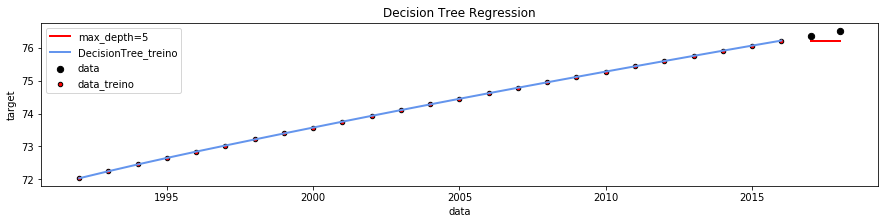

In [37]:
# Plot the results
plt.figure(figsize=(15, 3))

plt.scatter(x_data, y_teste, s=40, edgecolor="black", c="black", label="data")
plt.scatter(x_data2, y_treino, s=20, edgecolor="black", label="data_treino", c= 'red')

plt.plot(x_data, y_pred_teste, color="red", label="max_depth=5", linewidth=2)
plt.plot(x_data2, y_pred_treino, color="cornflowerblue", label="DecisionTree_treino", linewidth=2)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()